In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split, Dataset
from torchmetrics.functional.image import peak_signal_noise_ratio as tm_psnr
from torchmetrics.functional.image import structural_similarity_index_measure as tm_ssim
import torch.nn.utils.weight_norm as weight_norm
import torch.nn.functional as F
import numpy as np
import scipy as sp
from scipy.stats import norm, shapiro, binom
from scipy.special import beta
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import random
import time as t
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype, fetch_openml, fetch_20newsgroups
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
import os
import urllib
import gzip
import zipfile
import json
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import urllib.request
from sklearn.feature_extraction.text import TfidfVectorizer
import datasets 
from datasets import load_dataset
import seaborn as sns
import ipynbname
from collections import defaultdict
import piq

notebook_name = ipynbname.name()
# from torchtime.data import PhysioNet2012
# from torchtime.collate import packed_sequence

In [2]:
device_id = 7
device = "cuda:"+str(device_id) if torch.cuda.is_available() else 'cpu'

url = "https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
filename = "dsprites.npz"
urllib.request.urlretrieve(url, filename)

class dSpritesDataset(Dataset):
    def __init__(self, path="dsprites.npz"):
        data = np.load(path, allow_pickle=True, encoding='latin1')
        self.imgs = data['imgs']  # shape: (737280, 64, 64)
        self.latents = data['latents_classes']  # shape: (737280, 6)
        self.latents_factors = data['latents_values']  # shape: (737280, 6)
        self.imgs = torch.tensor(self.imgs, dtype=torch.float32).unsqueeze(1)  # add channel
        self.latents = torch.tensor(self.latents, dtype=torch.long)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.latents[idx]  # return image and latent class vector

def get_dsprites_loaders(batch_size=512, path="dsprites.npz"):
    dataset = dSpritesDataset(path)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)
    return train_loader, test_loader

train_loader, test_loader = get_dsprites_loaders()


In [3]:
class WValActivation(nn.Module):
    def __init__(self, activation_threshold: float, L: int = 256, beta_table=None):
        super().__init__()
        self.activation_threshold = torch.tensor(activation_threshold)
        self.L = L

        if beta_table is not None:
            self.register_buffer("beta_table", beta_table)
            self.table_size = beta_table.shape[0]
        else:
            raise ValueError("Precomputed beta_table must be provided.")

        self.register_buffer("entropy", torch.tensor(0.0))

    def forward(self, x):
        x_normed = F.normalize(x, p=2, dim=1)
        S = torch.clamp(x_normed ** 2, min=1e-8, max=1 - 1e-8)
        index = (S * (self.table_size - 1)).long().clamp(0, self.table_size - 1)
        cdf = self.beta_table[index]
        beta_surv = torch.clamp(1 - cdf, min=1e-8)
        w_val = -torch.log(beta_surv)

        result = torch.where(w_val >= self.activation_threshold, x, torch.zeros_like(x))

        # Activation entropy
        probs = x.pow(2).flatten()
        probs = probs / (probs.sum() + 1e-8)
        entropy = -(probs * torch.log(torch.clamp(probs, min=1e-12))).sum()
        self.entropy.copy_(entropy.detach())

        return result
        
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, mask_threshold=1.0, table={}):
        super().__init__(in_features, out_features, bias)
        self.mask_threshold = torch.tensor(mask_threshold)
        self.table = table
        self.register_buffer("w_values", torch.zeros_like(self.weight))
        self.register_buffer("entropy", torch.tensor(0.0))
        self.register_buffer("cached_mask", torch.zeros_like(self.weight))  # or initialize as zeros if you prefer


    def compute_wval(self, M):
        L = M.shape[1]
        M_normed = F.normalize(M, p=2, dim=1)
        M_sq = torch.clamp(M_normed ** 2, min=1e-8, max=1 - 1e-8)

        table_vals = self.table[L].to(M.device)
        index_matrix = (M_sq * (len(table_vals) - 1)).long().clamp(0, len(table_vals) - 1)
        cdf = table_vals[index_matrix]
        beta_surv = torch.clamp(1 - cdf, min=1e-8)
        w_val = -torch.log(beta_surv)
        return w_val.to(self.weight.device)

    def forward(self, input):
        # if self.cached_mask is None:
        #     with torch.no_grad():
        #         self.w_values = self.compute_wval(self.weight)
        #         self.cached_mask = (self.w_values >= self.mask_threshold).float()
        # masked_weight = self.weight * self.cached_mask
        if self.cached_mask is None or self.training:
            self.w_values = self.compute_wval(self.weight)
            self.cached_mask.copy_((self.w_values >= self.mask_threshold).float())

            # self.register_buffer("cached_mask", torch.zeroes_like(self.weight))  
    
        masked_weight = self.weight * self.cached_mask
        
        # Entropy of masked weights
        flat = masked_weight.view(-1).pow(2)
        probs = flat / (flat.sum() + 1e-8)
        entropy = -(probs * torch.log(torch.clamp(probs, min=1e-12))).sum()
        self.entropy.copy_(entropy.detach())

        return F.linear(input, masked_weight, self.bias)
        
class AE(nn.Module):
    def __init__(self, encoder_dims=[4096, 1024, 256], latent_dim=36,
                 dropout=0.3, activation_fn=nn.ReLU,
                 mask_threshold=0, activation_threshold=0):
        super().__init__()
        self.activation_threshold = activation_threshold

        # Precompute beta tables for all layer sizes
        dims = encoder_dims + [latent_dim] + encoder_dims[::-1] 
        self.table = {b: torch.tensor(sp.special.betainc(0.5, 0.5 * (b - 1), np.linspace(0, 1, 100000)), dtype=torch.float32)
                      for b in set(dims)}

        # Encoder
        encoder_layers = []
        enc_dims = encoder_dims + [latent_dim]
        for i in range(len(enc_dims) - 1):
            encoder_layers.append(MaskedLinear(enc_dims[i], enc_dims[i+1], mask_threshold=mask_threshold, table=self.table))
            if activation_threshold != 0:
                encoder_layers.append(WValActivation(activation_threshold=activation_threshold, L=enc_dims[i+1], beta_table=self.table[enc_dims[i+1]]))
            else:
                encoder_layers.append(activation_fn())

        # Decoder
        decoder_layers = []
        dec_dims = [latent_dim] + encoder_dims[::-1]
        for i in range(len(dec_dims) - 1):
            decoder_layers.append(MaskedLinear(dec_dims[i], dec_dims[i+1], mask_threshold=mask_threshold, table=self.table))
            if i < len(dec_dims) - 2:  # no activation on final output
                if activation_threshold != 0:
                    decoder_layers.append(WValActivation(activation_threshold=activation_threshold, L=dec_dims[i+1], beta_table=self.table[dec_dims[i+1]]))
                else:
                    decoder_layers.append(activation_fn())

        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        # Automatically flatten input if it's not already 2D
        if x.dim() > 2:
            x = x.view(x.size(0), -1)  # Flatten to [batch_size, features]
        
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# Sparse Autoencoder subclass
class SAE(AE):
    def __init__(self, encoder_dims=[4096, 1024, 256], latent_dim=36, activation_fn=nn.ReLU, mask_threshold=0, activation_threshold=0, lambda_l1=1e-3):
        super().__init__(
            encoder_dims=encoder_dims,
            latent_dim=latent_dim,
            dropout=0.3,
            activation_fn=activation_fn,
            mask_threshold=mask_threshold,
            activation_threshold=activation_threshold
        )

        self.lambda_l1 = lambda_l1

    def loss_fn(self, recon, x, z):
        mse = F.mse_loss(recon, x)
        l1 = self.lambda_l1 * torch.mean(torch.abs(z))
        return mse + l1


In [4]:
def compute_psnr(x, recon, max_pixel_value=1.0):
    mse = F.mse_loss(recon, x)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

def compute_ssim(x, recon):
    return piq.ssim(x, recon, data_range=1.0).mean().item()

def train_autoencoder(model, train_loader, test_loader, is_sparse=False, epochs=20, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, test_mses, test_psnrs, test_ssims = [], [], [], []

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon, z = model(x)

            x_flat = x.view(x.size(0), -1)
            recon_flat = recon.view(x.size(0), -1)

            loss = model.loss_fn(recon, x_flat, z) if is_sparse else F.mse_loss(recon_flat, x_flat)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        train_losses.append(total_loss / len(train_loader.dataset))
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}")

        if (epoch + 1) % 2 == 0 or (epoch + 1) == epochs:
            mse, psnr, ssim_val = evaluate_autoencoder(model, test_loader, is_sparse, device)
            test_mses.append(mse)
            test_psnrs.append(psnr)
            test_ssims.append(ssim_val)
            print(f"  Test MSE: {mse:.4f}, PSNR: {psnr:.2f}, SSIM: {ssim_val:.4f}")

    return train_losses, test_mses, test_psnrs, test_ssims


def evaluate_autoencoder(model, test_loader, is_sparse, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    total_psnr = 0.0
    total_ssim = 0.0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon, z = model(x)

            x_flat = x.view(x.size(0), -1)
            recon_flat = recon.view(x.size(0), -1)

            loss = model.loss_fn(recon, x_flat, z) if is_sparse else F.mse_loss(recon_flat, x_flat)
            total_loss += loss.item() * x.size(0)

            # Reshape for image metrics (assumes 64x64 grayscale)
            x_img = x.view(-1, 1, 64, 64)
            recon_img = recon.view(-1, 1, 64, 64)

            # GPU-native PSNR and SSIM
            total_psnr += tm_psnr(recon_img, x_img, data_range=1.0) * x.size(0)
            total_ssim += tm_ssim(recon_img, x_img, data_range=1.0) * x.size(0)

            total_samples += x.size(0)

    avg_mse = total_loss / total_samples
    avg_psnr = total_psnr / total_samples
    avg_ssim = total_ssim / total_samples

    return avg_mse, avg_psnr.item(), avg_ssim.item()



def compare_models(train_losses, test_mses, test_psnrs, test_ssims):
    plt.figure(figsize=(12, 4))
    for label, losses in test_mses.items():
        test_epochs = list(range(2, 2 * len(losses) + 1, 2))
        plt.plot(test_epochs, losses, label=label)
    plt.title("Test MSE Across Models")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 4))
    for label, psnrs in test_psnrs.items():
        test_epochs = list(range(2, 2 * len(psnrs) + 1, 2))
        plt.plot(test_epochs, psnrs, label=label)
    plt.title("PSNR Across Models")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 4))
    for label, ssims in test_ssims.items():
        test_epochs = list(range(2, 2 * len(ssims) + 1, 2))
        plt.plot(test_epochs, ssims, label=label)
    plt.title("SSIM Across Models")
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

# def extract_latents(model, data_loader, device):
#     model.eval()
#     all_z = []
#     with torch.no_grad():
#         for x, _ in data_loader:
#             x = x.to(device)
#             _, z = model(x)
#             all_z.append(z.cpu())
#     return torch.cat(all_z)

def extract_latents(model, data_loader, device):
    model.eval()
    all_z = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device, non_blocking=True)
            _, z = model(x)
            all_z.append(z)  # keep on GPU
    return torch.cat(all_z)  # still on GPU


# def plot_latent_traversal_subset(model, base_z, top_dims, device, n_steps=7, delta=3.0):
#     model.eval()
#     latent_dim = base_z.shape[0]
#     steps = torch.linspace(-delta, delta, steps=n_steps)

#     fig, axes = plt.subplots(len(top_dims), n_steps, figsize=(n_steps, len(top_dims)))
#     for row, dim in enumerate(top_dims):
#         for col, s in enumerate(steps):
#             z_mod = base_z.clone()
#             z_mod[dim] += s
#             z_mod = z_mod.unsqueeze(0).to(device)
#             with torch.no_grad():
#                 img = model.decoder(z_mod).view(64, 64).cpu().numpy()
#             axes[row, col].imshow(img, cmap='gray')
#             axes[row, col].axis("off")
#     plt.suptitle("Latent Traversals")
#     plt.tight_layout()
#     plt.show()

def plot_latent_traversal_subset(model, base_z, top_dims, device, n_steps=7, delta=3.0):
    model.eval()
    steps = torch.linspace(-delta, delta, steps=n_steps, device=base_z.device)

    fig, axes = plt.subplots(len(top_dims), n_steps, figsize=(n_steps, len(top_dims)))
    
    with torch.no_grad():
        for row, dim in enumerate(top_dims):
            for col, s in enumerate(steps):
                z_mod = base_z.clone()
                z_mod[dim] += s
                z_mod = z_mod.unsqueeze(0).to(device)
                img = model.decoder(z_mod)
                img = img.view(64, 64).detach().cpu().numpy()  # only now moved to CPU for plotting
                axes[row, col].imshow(img, cmap='gray')
                axes[row, col].axis("off")

    plt.suptitle("Latent Traversals")
    plt.tight_layout()
    plt.show()


In [5]:
def visualize_latent_sparsity(model, data_loader, device=device, epsilon=1e-3, num_batches=1):
    model = model.to(device)
    model.eval()
    all_latents = []

    with torch.no_grad():
        for i, (x, _) in enumerate(data_loader):
            if i >= num_batches:
                break
            x = x.to(device, non_blocking=True)
            if x.dim() > 2:
                x = x.view(x.size(0), -1)  # flatten to (batch_size, input_dim)
            z = model.encoder(x)  # on GPU
            all_latents.append(z)

    # Still on GPU
    Z = torch.cat(all_latents, dim=0)        # [N, latent_dim]
    Z_abs = Z.abs()                          # [N, latent_dim]
    sparsity_ratio = (Z_abs < epsilon).float().mean(dim=1)  # [N]

    # ---- PLOT 1: Latent Activation Heatmap ----
    plt.figure(figsize=(10, 6))
    sns.heatmap(Z_abs[:100].cpu().numpy(), cmap='viridis', cbar=True)
    plt.title("Latent Activation Heatmap (abs values, first 100 samples)")
    plt.xlabel("Latent Dimension")
    plt.ylabel("Sample Index")
    plt.tight_layout()
    plt.show()

    # ---- PLOT 2: Histogram of All Latent Values ----
    plt.figure(figsize=(8, 5))
    sns.histplot(Z.flatten().cpu().numpy(), bins=100, kde=True)
    plt.title("Histogram of Latent Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # ---- PLOT 3: Sparsity Ratio per Sample ----
    plt.figure(figsize=(6, 4))
    sns.histplot(sparsity_ratio.cpu().numpy(), bins=30)
    plt.title(f"Sparsity Ratio per Sample (|z_i| < {epsilon})")
    plt.xlabel("Fraction of Inactive Latent Units")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Final print from GPU → CPU
    print(f"Average sparsity: {sparsity_ratio.mean().item():.3f}")

In [20]:
SEED = torch.manual_seed(42)
EPOCH = 10

model_results = {}
test_mses = {}
times = {}
train_losses = {}
test_psnrs = {}
test_ssims = {} 

# Activation, act thresh, mask thresh, lambda_L1
configs = [
    # ("WFilter_t3", nn.ReLU, 0, -np.log(0.5), 0),
    ("Normal AE", nn.ReLU, 0, 0, 0 ),
    # ("Normal SAE", nn.ReLU, 0, 0, 1e-3),
    # ("WV_t1", WValActivation, -np.log(0.9), 0, 0),
    # ("WAct_t3", WValActivation, -np.log(0.5), 0, 0),
    # ("WV_t5", WValActivation, -np.log(0.1), 0, 0),

]

start = t.time()

for label, act, act_thresh, mask_thresh, lambda_L1 in configs:
    iter_i = t.time()
    
    sae = SAE(activation_fn=act, activation_threshold=act_thresh, mask_threshold=mask_thresh, lambda_l1=lambda_L1).to(device)
    train_loss, test_mse, test_psnr, test_ssim = train_autoencoder(model=sae, train_loader=train_loader, test_loader=test_loader, is_sparse=False, epochs=EPOCH)
    test_mses[label] = test_mse
    train_losses[label] = train_loss
    test_psnrs[label] = test_psnr
    test_ssims[label] = test_ssim
    model_results[label] = sae
    iter_f = t.time()
    delta = iter_f - iter_i
    print(delta)
    times[label] = delta

total = t.time() - start
print(total/60)  

Epoch 1/10 - Train Loss: 0.0067
Epoch 2/10 - Train Loss: 0.0044
  Test MSE: 0.0041, PSNR: 23.89, SSIM: 0.6741
Epoch 3/10 - Train Loss: 0.0039
Epoch 4/10 - Train Loss: 0.0037
  Test MSE: 0.0036, PSNR: 24.45, SSIM: 0.7172
Epoch 5/10 - Train Loss: 0.0035
Epoch 6/10 - Train Loss: 0.0033
  Test MSE: 0.0033, PSNR: 24.85, SSIM: 0.7607
Epoch 7/10 - Train Loss: 0.0032
Epoch 8/10 - Train Loss: 0.0031
  Test MSE: 0.0031, PSNR: 25.07, SSIM: 0.7933
Epoch 9/10 - Train Loss: 0.0031
Epoch 10/10 - Train Loss: 0.0030
  Test MSE: 0.0030, PSNR: 25.27, SSIM: 0.8177
322.9704782962799
5.382850205898285


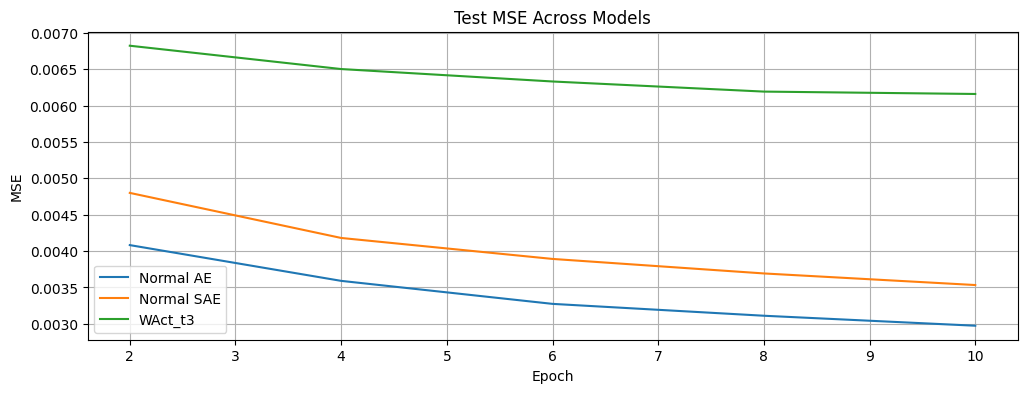

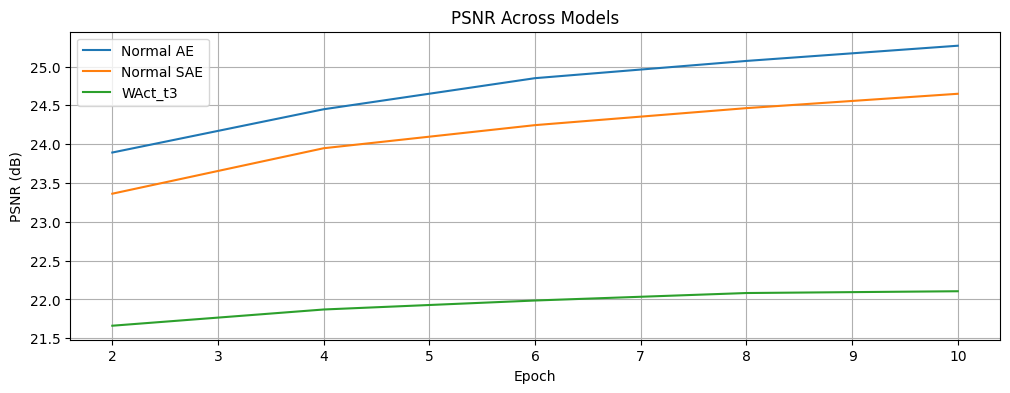

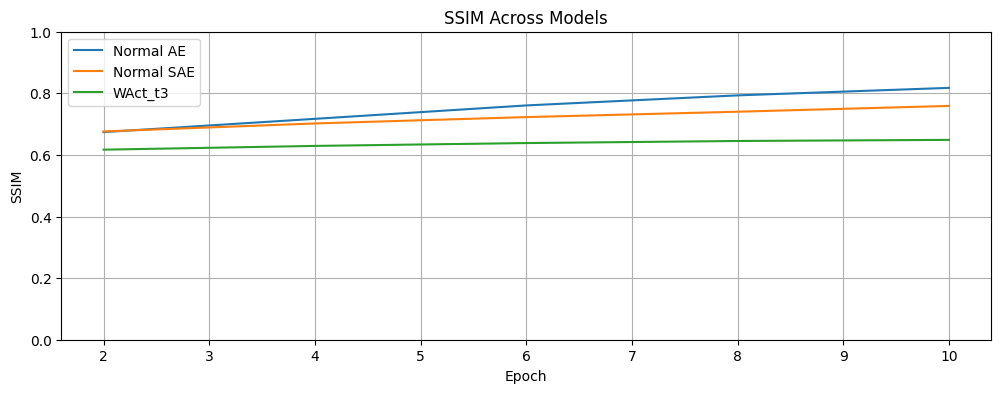

In [8]:
compare_models(train_losses, test_mses, test_psnrs, test_ssims)

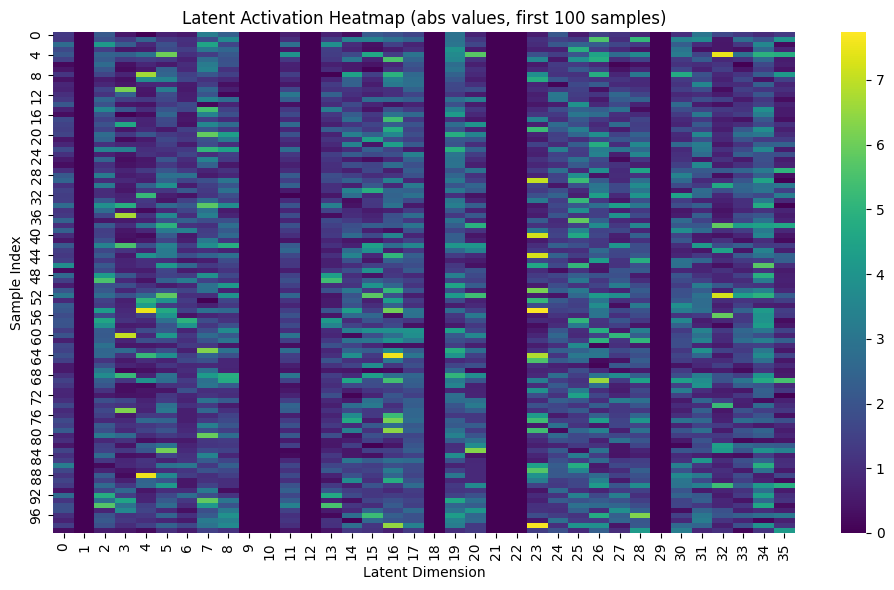

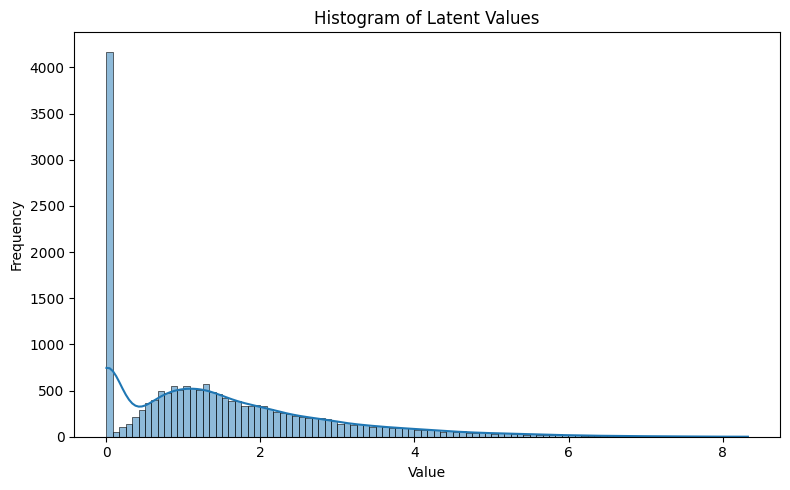

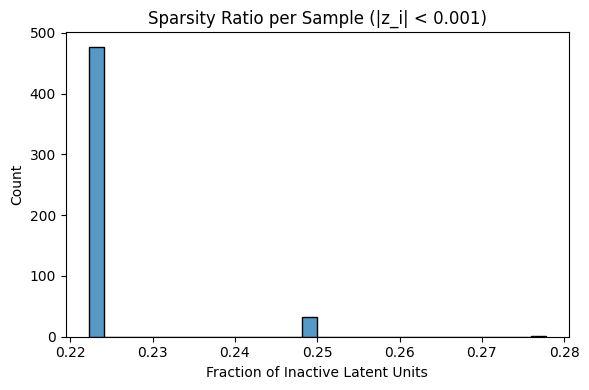

Average sparsity: 0.224


In [22]:
visualize_latent_sparsity(model_results["Normal AE"], test_loader, device)

In [22]:
def gen_traversal(model, loader, device):
    z_sae = extract_latents(model, loader, device)
    base_z = z_sae[0].to(device)
    top_dims = torch.argsort(base_z.abs(), descending=True)[:50]
    plot_latent_traversal_subset(model, base_z, top_dims, device)


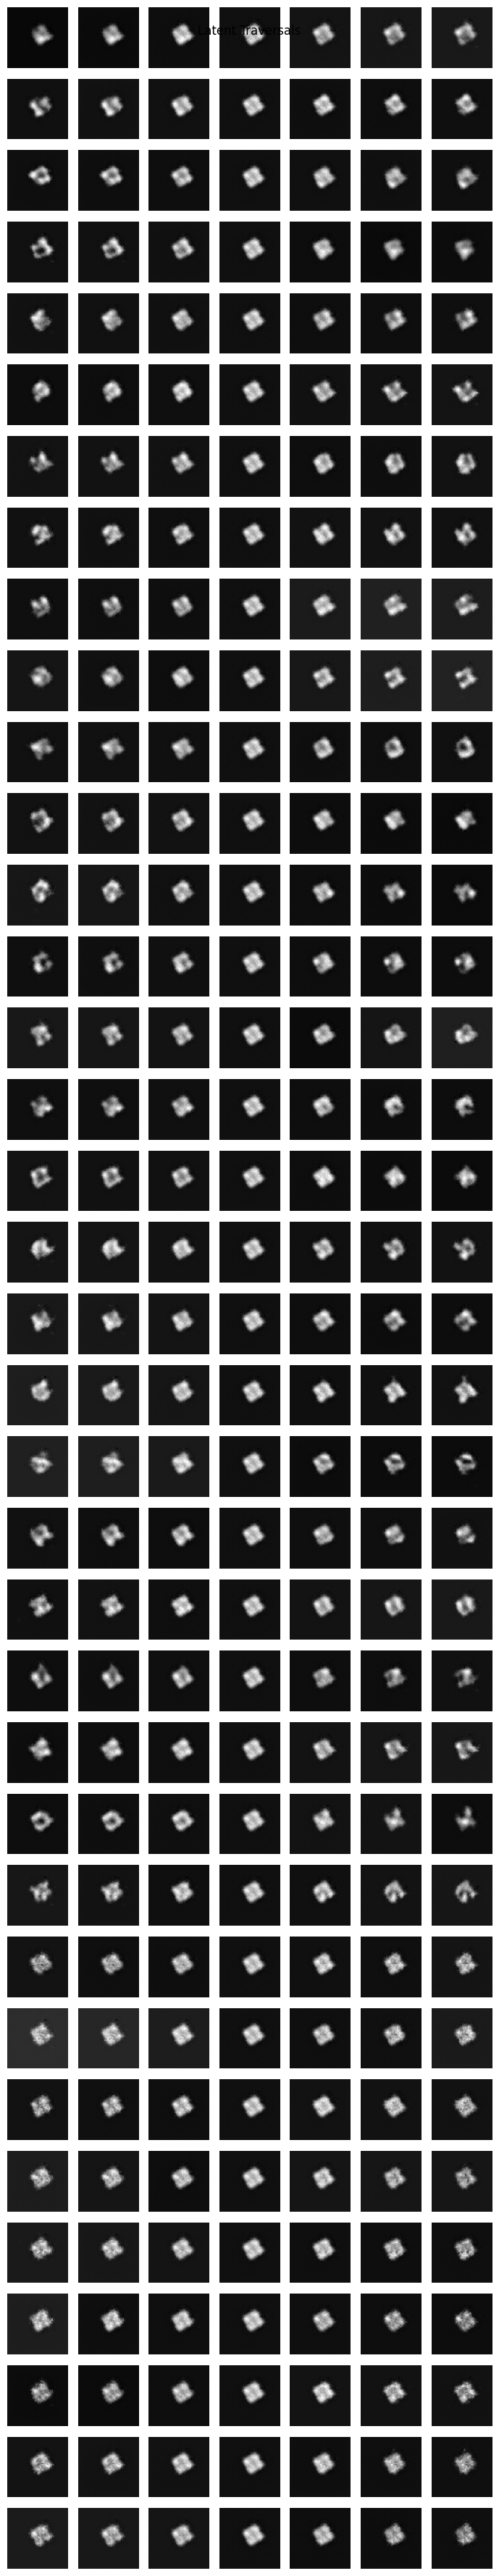

In [34]:
gen_traversal(model_results["WFilter_t3"], test_loader, device)

In [ ]:
print(next(model_results["WV_t1"].parameters()).device)
print(device)  # the device you're trying to evaluate on


In [ ]:
z_sae[0].shape

In [ ]:
device

In [ ]:
visualize_latent_sparsity(sae1, test_loader, device)

In [ ]:
# Latent Traversals
z_sae = extract_latents(sae1, test_loader, device)
base_z = z_sae[0].to(device)
top_dims = torch.argsort(base_z.abs(), descending=True)[:50]
plot_latent_traversal_subset(sae1, base_z, top_dims, device)


In [ ]:
def plot_weight_distribution(model, threshold=1e-5):
    all_weights = []
    near_zero_count = 0
    total_count = 0

    # Iterate over model parameters
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            weights = param.data.cpu().numpy().flatten()
            all_weights.extend(weights)
            # Count near-zero weights
            near_zero_count += (abs(weights) < threshold).sum()
            total_count += weights.size

            # Plot histogram for this layer
            plt.figure()
            plt.hist(weights, bins=100, alpha=0.7)
            plt.title(f'Weight distribution: {name}')
            plt.xlabel('Weight value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

    # Summary across all layers
    all_weights = torch.tensor(all_weights)
    overall_sparsity = (abs(all_weights) < threshold).sum().item() / all_weights.numel() * 100

    print(f"Overall near-zero weights (< {threshold}): {overall_sparsity:.2f}% of total weights")
